In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

class DataLoader:

  def __init__(self, batch_size, seq_len, pred_len):
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.target_slice = slice(0, None)

    self._read_data()

  def _read_data(self):

    url = 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv'

    df_raw = pd.read_csv(url)
    df = df_raw.set_index('date')

    # split train/valid/test
    n = len(df)
    train_end = int(n * 0.7)
    val_end = n - int(n * 0.2)
    test_end = n

    train_df = df[:train_end]
    val_df = df[train_end - self.seq_len : val_end]
    test_df = df[val_end - self.seq_len : test_end]

    # standardize by training set
    self.scaler = StandardScaler()
    self.scaler.fit(train_df.values)

    def scale_df(df, scaler):
      data = scaler.transform(df.values)
      return pd.DataFrame(data, index=df.index, columns=df.columns)

    self.train_df = scale_df(train_df, self.scaler)
    self.val_df = scale_df(val_df, self.scaler)
    self.test_df = scale_df(test_df, self.scaler)
    self.n_feature = self.train_df.shape[-1]

  def _split_window(self, data):
    inputs = data[:, : self.seq_len, :]
    labels = data[:, self.seq_len :, self.target_slice]

    inputs.set_shape([None, self.seq_len, None])
    labels.set_shape([None, self.pred_len, None])
    return inputs, labels

  def _make_dataset(self, data, shuffle=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=(self.seq_len + self.pred_len),
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=self.batch_size,
    )
    ds = ds.map(self._split_window)
    return ds

  def inverse_transform(self, data):
    return self.scaler.inverse_transform(data)

  def get_train(self, shuffle=True):
    return self._make_dataset(self.train_df, shuffle=shuffle)

  def get_val(self):
    return self._make_dataset(self.val_df, shuffle=False)

  def get_test(self):
    return self._make_dataset(self.test_df, shuffle=False)

In [6]:
data_loader = DataLoader(batch_size=32, seq_len=512, pred_len=96)

train_data = data_loader.get_train()
val_data = data_loader.get_val()
test_data = data_loader.get_test()

In [7]:
from tensorflow.keras import layers

def res_block(inputs, ff_dim):

  norm = layers.BatchNormalization

  # Time mixing
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation='relu')(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.7)(x)
  res = x + inputs

  # Feature mixing
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(0.7)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.7)(x)
  return x + res

In [8]:
def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  # Temporal projection
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)

In [9]:
model = build_model(
    input_shape=(512, data_loader.n_feature),
    pred_len=96,
    n_block=8,
    ff_dim=64,
    target_slice=data_loader.target_slice
)

In [10]:
tf.keras.utils.set_random_seed(42)

optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(optimizer, loss='mse', metrics=['mae'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tsmixer_checkpoints/',
    vebose=1,
    save_best_only=True,
    save_weights_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

history = model.fit(
    train_data,
    epochs= 10,
    validation_data=val_data,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/10
363/363 [==============================] - 54s 126ms/step - loss: 26.8927 - mae: 4.0228 - val_loss: 0.9642 - val_mae: 0.7622
Epoch 2/10
363/363 [==============================] - 45s 123ms/step - loss: 10.7101 - mae: 2.5656 - val_loss: 0.7705 - val_mae: 0.6909
Epoch 3/10
363/363 [==============================] - 45s 124ms/step - loss: 6.0682 - mae: 1.9307 - val_loss: 0.7257 - val_mae: 0.6760
Epoch 4/10
363/363 [==============================] - 45s 125ms/step - loss: 3.9191 - mae: 1.5497 - val_loss: 0.6644 - val_mae: 0.6431
Epoch 5/10
363/363 [==============================] - 44s 122ms/step - loss: 2.7303 - mae: 1.2907 - val_loss: 0.6207 - val_mae: 0.6165
Epoch 6/10
363/363 [==============================] - 45s 123ms/step - loss: 2.0076 - mae: 1.1031 - val_loss: 0.5954 - val_mae: 0.6007
Epoch 7/10
363/363 [==============================] - 44s 122ms/step - loss: 1.5244 - mae: 0.9577 - val_loss: 0.5657 - val_mae: 0.5799
Epoch 8/10
363/363 [==============================] -

In [11]:
best_epoch = np.argmin(history.history['val_loss'])

model.load_weights("tsmixer_checkpoints/")

In [12]:
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

scaled_preds.shape

106/106 [==============================] - 3s 24ms/step


(96, 7)

In [27]:
cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols

preds = data_loader.inverse_transform(scaled_preds)

preds_df = pd.DataFrame(preds)
preds_df.columns = cols

preds_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,9.324182,1.951663,6.474066,0.361964,2.818494,0.863441,7.377808
1,10.289113,2.109972,8.076525,0.751616,2.662027,0.865520,7.168252
2,10.855426,2.563483,7.906673,0.875186,3.027822,0.892317,7.260201
3,11.702411,2.699140,8.586838,1.124456,3.056572,0.855161,7.388008
4,12.182331,3.025669,8.701064,1.237783,3.288065,0.855856,7.574347


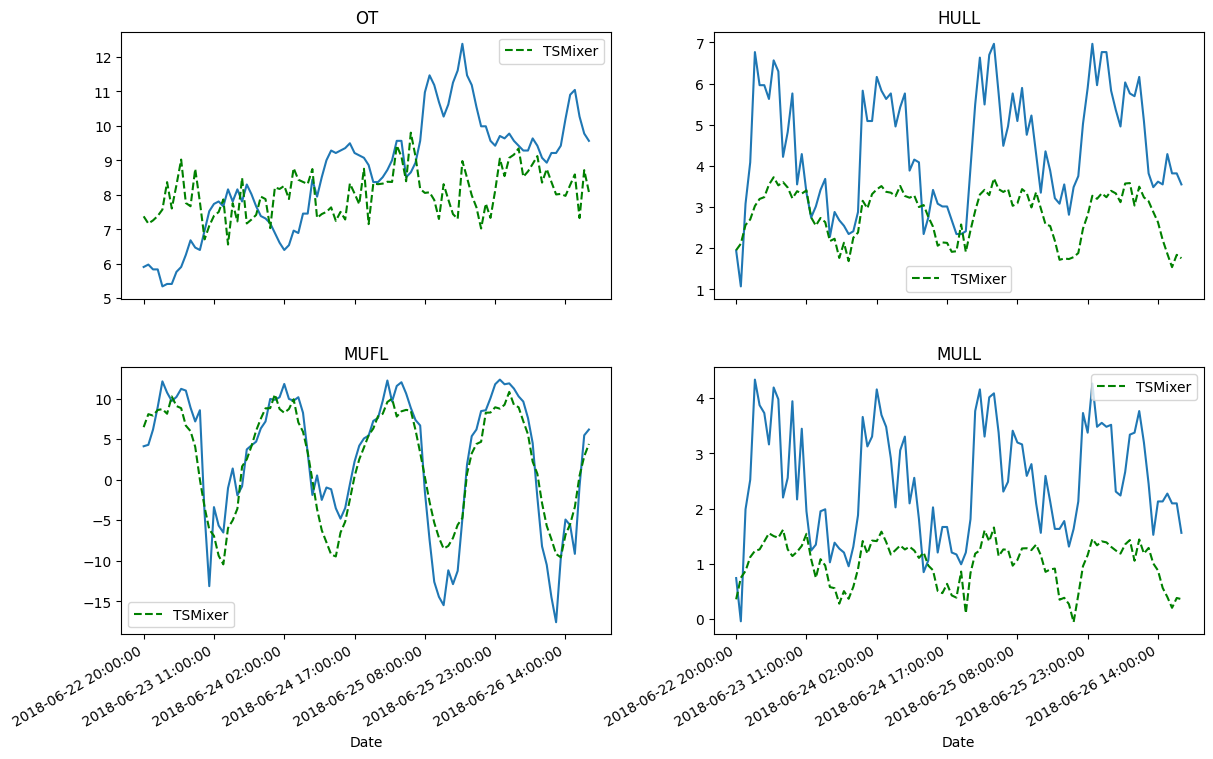

In [28]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv')
df = df_raw.set_index('date')

cols_to_plot = ['OT', 'HULL', 'MUFL', 'MULL']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    col = cols_to_plot[i]
    
    ax.plot(df[col][-96:])
    ax.plot(preds_df[col], label='TSMixer', ls='--', color='green')
    
    ax.legend(loc='best')
    ax.set_xlabel('Date')
    ax.set_title(col)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    
plt.tight_layout()
fig.autofmt_xdate()

## Evaluation

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual = df[-96:]

tsmixer_mae = mean_absolute_error(actual, preds_df) 
tsmixer_mse = mean_squared_error(actual, preds_df)

In [31]:
print(tsmixer_mae, tsmixer_mse)

1.673110596062283 5.371198938424058
